Amparo Godoy Pastore </br>
April 28th, 2023
 

<h1 style="text-align: center;">Impact of Precipitation on Wheat, Corn, and Soybean Yield in Buenos Aires, Argentina (1993 - 2022)</h1>

# Table of Contents

1. [Introduction](#first-bullet)
2. [Preliminaries](#second-bullet)
3. [Data Collection](#third-bullet)
4. [Visualization](#fourth-bullet)
5. [Precipitations vs. Crop Yield](#fifth-bullet)
6. [Introducing other independent variables](#sixth-bullet)
7. [Discussion](#seventh-bullet)

# 1. Introduction <a class="anchor" id="first-bullet"></a>

Argentina is a country highly dependent on its agricultural sector, which represents a significant part of its economy. The province of Buenos Aires is among the most important agricultural regions, producing a significant portion of the country's crops. However, agricultural production in this region is highly vulnerable to changes in weather patterns, particularly rainfall.

In recent years, the impact of rainfall on agricultural production has become a topic of increasing concern in Argentina. As reported by Agrositio, the dry climate and high temperatures have been affecting crop yields and impacting the profitability of farmers in these regions. 

This project aims to analyze the impact of precipitations on agricultural production in Argentina's most important agricultural region, where alternative irrigation methods are limited. Our primary goal is to examinate how strong of a correlation, if any, there is between precipitations and crop yield, and assess whether it is a good predictor for crop yield. 

# 2. Preliminaries <a class="anchor" id="second-bullet"></a>

Here, we import the necessary modules.

In [3]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from meteostat import Normals, Stations, Daily, Monthly, Point
from sklearn.linear_model import LinearRegression
import folium
import matplotlib.dates as mdates
import plotly.graph_objects as go
import seaborn as sns
from sklearn.cluster import KMeans
import statsmodels.api as sm
from scipy.stats import pearsonr
from IPython.display import display, HTML
from scipy.stats import spearmanr, kendalltau

# 3. Data collection <a class="anchor" id="third-bullet"></a>


## 3.2 Precipitation Data

We start by collecting precipitation data for the study area of Buenos Aires, Argentina, from the **Meteostat Python library**. This data will be used to investigate the relationship between precipitation and crop yield and ultimately provide insights into the factors that affect agricultural productivity in the region.

To collect the precipitation data, we first search for weather stations in the area using the `Stations()` function. We then filter these stations based on their proximity to Buenos Aires. Finally, we visualize the distribution of these stations on a map to see how much coverage we have of the study area.

In [50]:
# Search for weather stations in Buenos Aires
stations = Stations()
# Finding nearby stations
stations = stations.nearby(-34.603722, -58.381592).fetch().query('timezone == "America/Argentina/Buenos_Aires"')
# Set boundaries for the North and South
stations = stations.loc[(stations["latitude"] < -33.326321) & (stations["latitude"] > -40.821350)] 

# Now we need to look at the distribution of the stations to see where the data is coming from
m = folium.Map()
coord = list(zip(stations['latitude'], stations['longitude']))
for point in coord:
    folium.CircleMarker(point, fill = True, color = "#EA047E", fill_opacity = 1, radius = 2).add_to(m)

#Resize map to fit data
m.fit_bounds(m.get_bounds(), padding = (10, 10))

#Display
display(m)

While a single weather station may provide accurate information on the precipitation at that location, it may not be representative of the precipitation patterns in the surrounding areas. By selecting multiple weather stations that are representative of different regions in the study area, we can capture the spatial variability of precipitation and better understand how it affects crop yield.

For this purpose, we are using `K-Means` clustering to group the weather stations in Buenos Aires into three clusters and select one station from each cluster. We get the labels assigned to each station by the clustering algorithm using the `.labels_` attribute of the kmeans object. Next, we find the index of the station closest to the center of each cluster. Lastly, we use `.iloc[]` to index the stations DataFrame using the indices list we created earlier. These selected stations will be used to compute the average monthly precipitations for Buenos Aires. 

In [5]:
# Create a numpy array of the latitudes and longitudes of the stations
coords = np.array(list(zip(stations['latitude'], stations['longitude'])))

# Use K-Means clustering to group the stations into clusters
n_clusters = 3 # choose the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(coords)
labels = kmeans.labels_

# Get the index of the station closest to the centroid of each cluster
indices = [] # Contains indices of selected stations 
for i in range(n_clusters):
    # Loop over each cluster and get the indices of the stations assigned to that cluster
    cluster_indices = np.where(labels == i)[0]
    center = kmeans.cluster_centers_[i] # Get the center of the cluster
    distances = np.linalg.norm(coords[cluster_indices] - center, axis=1)
    closest_index = cluster_indices[np.argmin(distances)] # Get the index of the station with the shortest distance to the center
    indices.append(closest_index)

# Get the selected stations and compute the average of their forecasts
selected_stations = stations.iloc[indices]

Let's visualize the location of the selected weather stations on the map to confirm that we have enough coverage of the study area.

In [49]:
# Creating numpy array of coordinates for selected stations
coords2 = np.array(list(zip(selected_stations['latitude'], selected_stations['longitude'])))

# Map
n = folium.Map()
for point in coords2:
    folium.CircleMarker(point, fill = True, color = "#EA047E", fill_opacity = 1, radius = 5).add_to(n)
    
#Resize map to fit data
n.fit_bounds(n.get_bounds(), padding = (10, 10))
display(n)

After selecting the three weather stations that are representative of the Buenos Aires region, we now need to collect precipitation data from each station. We set the time period of interest from January 1, 1993 to December 31, 2022 and fetch daily precipitation data for each point. We then average the daily precipitation data from the three stations to get the overall precipitation for the region, and calculate mean monthly precipitations. The data is stored in a DataFrame `prcp`.

In [7]:
# Set time period
start = datetime(1993, 1, 1)
end = datetime(2022, 12, 31)

# Stores dataframes
dfs = []

# Loop through each station and create point and fetch daily data
for i in range(n_clusters):
    S = Point(coords2[i,0], coords2[i,1])
    df = Daily(S, start, end).fetch()
    dfs.append(df)

# Averaging the Daily precipitations from the stations
prcp = pd.concat(dfs).groupby('time', as_index=True).agg({'prcp':'mean'})

# Now getting monthly mean precipitations
prcp = prcp.groupby([(prcp.index.year), (prcp.index.month)]).mean()
prcp['Year'] = prcp.index.get_level_values(0)
prcp.head()

prcp  Year
time time                
1993 1     2.987634  1993
     2     3.147222  1993
     3     6.974405  1993
     4     6.140741  1993
     5     2.915054  1993

## 3.2 Crop Yield Data

In order to understand the relationship between crop yield and precipitation, we need to collect data on crop yields in Buenos Aires. The dataset we will be using is called Estimaciones.xlsx and it is publicly available on the website of the **Argentinian Ministry of Agriculture, Livestock, and Fisheries**. The dataset contains information on crop yields for different provinces in Argentina, broken down by crop type and crop season from 1992/93 to 2021/22.

For our analysis, we will focus on the province of Buenos Aires and the variable "Rendimiento" (yield), which is measured in tons per hectare. We will create a new dataframe called "crops" that includes only the data for Buenos Aires province. The dataframe contains columns for crop type, crop season, province, area planted, area harvested, production, and yield. We will be using the yield variable to investigate the relationship between precipitation and crop yield in the region.

In [8]:
# Data frame for crops
cropsdf = pd.read_excel('Estimaciones.xlsx')
crops = cropsdf[cropsdf.Provincia == "BUENOS AIRES"]
crops.tail(5)

,Cultivo,Campaña,Provincia,idProvincia,Sup. Sembrada,Sup. Cosechada,Producción,Rendimiento
205,Trigo total,2017/18,BUENOS AIRES,6.0,1989714.0,1969969.0,7611227.0,3864.0
206,Trigo total,2018/19,BUENOS AIRES,6.0,2342984.0,2258598.0,9017580.0,3993.0
207,Trigo total,2019/20,BUENOS AIRES,6.0,2484078.0,2410907.0,7810038.0,3239.0
208,Trigo total,2020/21,BUENOS AIRES,6.0,2747910.0,2734339.0,10480586.0,3833.0
209,Trigo total,2021/22,BUENOS AIRES,6.0,2601214.0,2539045.0,9687585.0,3815.0


#  4. Visualization <a class="anchor" id="fourth-bullet"></a>

In this section, we visualize the data from both DataFrames to analyze trends and anomalies.

## 4.1 Historical precipitation data

The bar plot below (_Figure 1_) shows the monthly precipitation anomalies from 1993 to 2022. An anomaly represents the difference between a value and the average value of that same parameter for a certain time period. In this case, the anomalies are calculated by subtracting the average of all monthly precipitations from the original data. 

From 1993 to 2019, the anomalies fluctuate above and below the average. However, since 2020, most monthly precipitation anomalies have been below the average line, indicating a consistent decrease in precipitation levels. This coincides with the state of agricultural emergency the Argentine government declared due to droughts in the region. Furthermore, the website, Agrositio, reports that the government has extended the agricultural emergency, suggesting that the current trend of below-average precipitation levels is likely to continue, potentially impacting crop yields in the future. Overall, the plot highlights the need for further analysis of the effects of these precipitation patterns on crop yields.

In [33]:
# Calculate mean monthly precipitations
mean_prcp = prcp.mean()

# Calculate anomalies
prcp_anomalies = prcp - mean_prcp

# Convert the multi-level index to a DatetimeIndex with the format %y%m
prcp_anomalies.index = pd.to_datetime(prcp_anomalies.index.get_level_values(0).astype(str) + 
                                      prcp_anomalies.index.get_level_values(1).astype(str), format='%Y%m')

# Colors for the map
# Choose the extreme colours of the colour map
colours = ["#FAA7C1", "#ED4A7D"]

# Colormap - Build the colour maps
cmap = mpl.colors.LinearSegmentedColormap.from_list("colour_map", colours, N=256)
norm = mpl.colors.Normalize(prcp_anomalies['prcp'].min(), prcp_anomalies['prcp'].max()) # linearly normalizes data into the [0.0, 1.0] interval

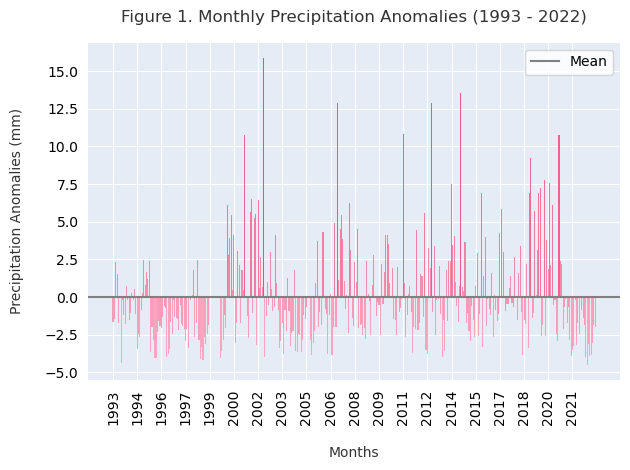

In [106]:
# Create a bar plot of the monthly precipitation anomalies
fig, ax = plt.subplots()
ax.bar(prcp_anomalies.index.astype(str), np.array(prcp_anomalies['prcp']), color = cmap(norm(np.array(prcp_anomalies['prcp']))))

# Add a horizontal line at y=0 to indicate the average
ax.axhline(y=0, color='grey', label = 'Mean')
ax.legend()

# Set the x-tick labels
ax.set_xticks(prcp_anomalies.index.astype(str)[::18])
ax.set_xticklabels([str(val)[:4] for val in prcp_anomalies.index.astype(str)[::18]], rotation=90)

# Add axis labels and a title
ax.set_xlabel('Months', labelpad=15, color='#333333')
ax.set_ylabel('Precipitation Anomalies (mm)', labelpad=15, color='#333333')
ax.set_title('Figure 1. Monthly Precipitation Anomalies (1993 - 2022)', pad=15, color='#333333')

# Change spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Add a horizontal grid,keep the vertical grid hidden
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='white')
ax.xaxis.grid(True, color='white')
ax.tick_params(left = False, bottom = False)
ax.set_facecolor('#E5ECF6')

fig.tight_layout() 
plt.show()

## 4.2 Wheat, Soybean, and Corn Yield Trends

Now, we plot crop yield over the last three decades to identify trends and characteristics of each crop. As we can see, from _Figure 2_, some crops have higher yields than others. Corn, for example, seems to have the highest yield across most years, while soybean and wheat have a relatively lower yield. Additionally, we can observe that the yield for all crops in Buenos Aires was affected by a major drought in 2018, leading to a decrease in the yield for all crops.

In [91]:
# Create an array with the colors
pal = ["#E97297", "#D8AD2C", "#BFD786"]

# List crops for plotting
list_crop = list(set(crops['Cultivo']))

# Plot crop yield
fig = go.Figure()
for c, p in zip(list_crop, pal):
    fig.add_trace(go.Scatter(x= crops[crops['Cultivo']==c]['Campaña'],
                             y= crops[crops['Cultivo']==c]['Rendimiento'],
                             name = c,
                             line_color = p,
                             fill = None))
    
fig.update_layout(title='Figure 2. Yield by Crop in Buenos Aires (1992 - 2022)',
                  xaxis_title="Year",
                  yaxis_title="Yield (t/ha)")

fig.show()

# 5. Precipitations vs. Crop Yield <a class="anchor" id="fifth-bullet"></a>

This section of the notebook explores whether there is a correlation between precipitation and crop yield in Buenos Aires. 

#### Scatterplot: Precipitations vs. Crop Yield

First we plot the mean annual precipitations against crop yield to get a sense of whether there is a linear relationship between the two variables. 

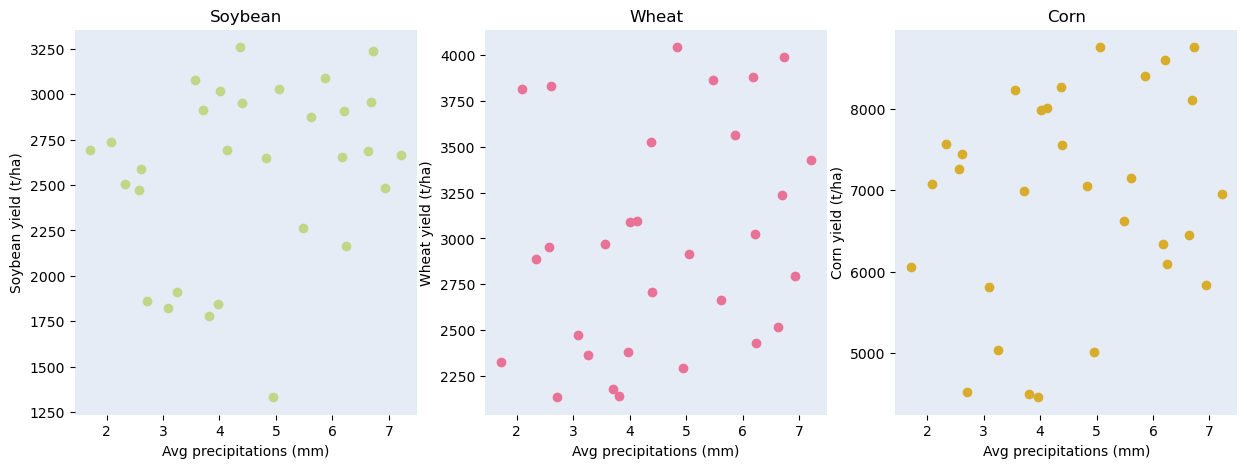

In [108]:
# Create subplots for each crop
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Scatterplot for soybean
axs[0].scatter(list(prcp['prcp'].groupby(prcp['Year']).mean()), 
               list(crops[crops['Cultivo'] == 'Soja total']['Rendimiento']), color = '#BFD786')
axs[0].set_xlabel('Avg precipitations (mm)')
axs[0].set_ylabel('Soybean yield (t/ha)')
axs[0].set_title('Soybean')
axs[0].set_facecolor('#E5ECF6')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['left'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)

# Scatterplot for wheat
axs[1].scatter(list(prcp['prcp'].groupby(prcp['Year']).mean()), 
               list(crops[crops['Cultivo'] == 'Trigo total']['Rendimiento']), color = '#E97297')
axs[1].set_xlabel('Avg precipitations (mm)')
axs[1].set_ylabel('Wheat yield (t/ha)')
axs[1].set_title('Wheat')
axs[1].set_facecolor('#E5ECF6')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)

# Scatterplot for corn
axs[2].scatter(list(prcp['prcp'].groupby(prcp['Year']).mean()), 
               list(crops[crops['Cultivo'] == 'Maíz']['Rendimiento']), color = '#D8AD2C')
axs[2].set_xlabel('Avg precipitations (mm)')
axs[2].set_ylabel('Corn yield (t/ha)')
axs[2].set_title('Corn')
axs[2].set_facecolor('#E5ECF6')
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].spines['left'].set_visible(False)
axs[2].spines['bottom'].set_visible(False)

# fig.set_facecolor('#F4EDE5')


plt.show()

From the scatterplots above, there is no clear linear relationship between the variables being plotted.  The relationship between the variables may be non-linear or there may be other factors that affect the relationship. In this case, it is likely that other variables, such as temperature or soil quality, are affecting crop yield in addition to precipitation. 

#### Spearman's correlation coefficient and Kendall's tau. Mean annual precipitation vs. Crop yield.

To further investigate the relationship, we turned to two nonparametric correlation measures: Spearman's rank correlation coefficient and Kendall's tau. These measures do not assume a linear relationship between the variables and are therefore more suitable for testing nonlinear relationships.

If the results of Spearman's rank correlation coefficient and Kendall's tau are not statistically significant, it would give us confirmation that other variables are affecting crop production, and that precipitation alone may not be a strong predictor of crop yields for these three crops.

In [13]:
# create a list of dictionaries to store the results
results = []

# define the crops and corresponding column names in the crops DataFrame
crops_dict = {
    'Soybean': 'Soja total',
    'Wheat': 'Trigo total',
    'Corn': 'Maíz'
}

# get the mean annual precipitation for each year
prcp_mean = prcp.groupby('Year').mean()['prcp'].tolist()

# loop over the crops and compute the correlations
for crop, colname in crops_dict.items():
    # get the crop yield data
    crop_yield = crops[crops['Cultivo'] == colname]['Rendimiento'].tolist()
    
    # compute the Spearman's correlation coefficient and p-value
    corr_spearman, pval_spearman = spearmanr(prcp_mean, crop_yield)
    
    # compute the Kendall's correlation coefficient and p-value
    corr_kendall, pval_kendall = kendalltau(prcp_mean, crop_yield)
    
    # add the results to the list of dictionaries
    results.append({
        'Crop': crop,
        'Spearman\'s correlation coefficient': corr_spearman,
        'Spearman\'s p-value': pval_spearman,
        'Kendall\'s correlation coefficient': corr_kendall,
        'Kendall\'s p-value': pval_kendall
    })

# create a DataFrame from the results
results_df = pd.DataFrame(results)

# set the Crop column as the index
results_df.set_index('Crop', inplace=True)

# display the results
results_df

,Spearman's correlation coefficient,Spearman's p-value,Kendall's correlation coefficient,Kendall's p-value
Crop,,,,
Soybean,0.238710,0.203953,0.140230,0.287111
Wheat,0.298776,0.108756,0.222989,0.086799
Corn,0.196885,0.297034,0.131034,0.320674


Looking at the results of the Spearman's correlation coefficient and Kendall's tau tests, we can see that for soybean, wheat, and corn, the values are all positive, indicating a positive association between crop yield and precipitation. However, only the correlation coefficient for wheat is somewhat statistically significant at the 0.05 level, with a p-value of 0.108756 for Spearman's and 0.086799 for Kendall's.

For soybean and corn, the p-values are greater than 0.05, indicating that there is not enough evidence to reject the null hypothesis and that there is no significant correlation between crop yield and precipitation. This suggests that other factors may be affecting crop production for these crops, and further investigation is needed.

#### Spearman's correlation coefficient and Kendall's tau. Mean precipitation of selected months vs. Crop yield. Crop's Growing Period.

However, we also know that the growing period of each crop is different and spans over specific months. Therefore, we will modify our analysis to select only the months that correspond to the growing period of each crop and evaluate its effect on the correlation coefficients and p-values. Soybean is grown from October to January, wheat from June to December, and corn from September to January.

In [14]:
# Create index lists to select rows corresponding to desired months
months = [9, 10, 11, 12, 1]
months2 = [6, 7, 8, 9, 10, 11, 12]

# Select the rows corresponding to the desired months
selected = prcp.loc[prcp.index.get_level_values(1).isin(months)].groupby(prcp['Year']).mean()
selected2 = prcp.loc[prcp.index.get_level_values(1).isin(months2)].groupby(prcp['Year']).mean()

# Select relevant variable
x1 = list(selected['prcp'])
x2 = list(selected2['prcp'])

# create a list of dictionaries to store the results
results = []

# define the crops and corresponding column names in the crops DataFrame
crops_dict = {
    'Soybean': 'Soja total',
    'Wheat': 'Trigo total',
    'Corn': 'Maíz'
}

# # get the mean annual precipitation for each year
# prcp_mean = prcp.groupby('Year').mean()['prcp'].tolist()

# loop over the crops and compute the correlations
for crop, colname in crops_dict.items():
    
    # get the crop yield data
    if crop in ['Corn', 'Soybean']:
        x = x1
    elif crop == 'Wheat':
        x = x2
        
    # get the crop yield data
    crop_yield = crops[crops['Cultivo'] == colname]['Rendimiento'].tolist()
    
    # compute the Spearman's correlation coefficient and p-value
    corr_spearman, pval_spearman = spearmanr(x, crop_yield)
    
    # compute the Kendall's correlation coefficient and p-value
    corr_kendall, pval_kendall = kendalltau(x, crop_yield)
    
    # add the results to the list of dictionaries
    results.append({
        'Crop': crop,
        'Spearman\'s correlation coefficient': corr_spearman,
        'Spearman\'s p-value': pval_spearman,
        'Kendall\'s correlation coefficient': corr_kendall,
        'Kendall\'s p-value': pval_kendall
    })

# create a DataFrame from the results
results_df = pd.DataFrame(results)

# set the Crop column as the index
results_df.set_index('Crop', inplace=True)

# display the results
results_df

,Spearman's correlation coefficient,Spearman's p-value,Kendall's correlation coefficient,Kendall's p-value
Crop,,,,
Soybean,0.239155,0.203086,0.112644,0.395032
Wheat,0.335261,0.070126,0.250575,0.053447
Corn,0.204449,0.278484,0.140230,0.287111


The analysis was again conducted separately for each crop, and the results suggest that precipitation has a slightly stronger positive correlation with wheat yield than with soybean and corn yields. Kendall's p-value for wheat is somewhat statistically significant, with 0.053447. Interestingly, we find that the correlation coefficients between precipitation and yield for wheat have increased in both tests compared to the annual analysis. For soybean and corn, the correlation coefficients remain relatively unchanged. As with the annual analysis, the p-values are still high, meaning that the results should be interpreted with caution.

We cannot conclude with certainty that there is a significant correlation between precipitation and crop yield. Precipitation may have an effect on crop yield, but results show that this factor alone is not a good indicator of crop yield. Other factors such as temperature, soil quality, and pest management should also be considered.

# 6. Introducing other independent variables <a class="anchor" id="sixth-bullet"></a>

In light of the results from the previous section, where we found that only wheat showed a somewhat statistically significant positive correlation with precipitation, while soybean and corn did not, we need to explore other independent variables that may be affecting the yield of these crops. Therefore, in this section, we will incorporate daily average temperature and wind speed. By including these variables in our analysis, we hope to shed light on the factors that influence crop production in Buenos Aires, Argentina.

In [15]:
# Averaging the Daily precipitations from the stations
weather = (pd.concat(dfs).groupby(level='time').agg({'prcp':'mean', 'tavg':'mean', 'wspd':'mean'}))

# # Now getting monthly mean precipitations
weather = weather.groupby([(weather.index.year), (weather.index.month)]).mean()
weather['Year'] = weather.index.get_level_values(0)
weather = weather.groupby(weather['Year']).mean()

# Reload crop data
soybean_yield = crops[crops['Cultivo'] == 'Soja total']
soybean_yield.loc[:,('Year')] = crops['Campaña'].str[:4].astype(int)
wheat_yield = crops[crops['Cultivo'] == 'Trigo total']
wheat_yield.loc[:,('Year')] = crops['Campaña'].str[:4].astype(int)
corn_yield = crops[crops['Cultivo'] == 'Maíz']
corn_yield.loc[:,('Year')] = crops['Campaña'].str[:4].astype(int)

C:\Users\ampig\AppData\Local\Temp\ipykernel_7460\4282182627.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ampig\AppData\Local\Temp\ipykernel_7460\4282182627.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ampig\AppData\Local\Temp\ipykernel_7460\4282182627.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

To incorporate the new variables, we will concatenate the weather data with the crop yield data for soybean, corn, and wheat. Then, we will use ordinary least squares (OLS) regression to model the relationship between the independent variables (precipitation, daily average temperature, and wind speed) and the dependent variable (crop yield). 

First, the weather data is merged with the crop yield data using the common variable 'Year'. Then, the independent variables (precipitation, temperature, and wind speed) are selected and a constant is added to the model using the statsmodels library. This allows us to estimate the baseline or mean value of the dependent variable  when all of the independent variables are equal to zero. The dependent variable is the crop yield, and the model is fit using the OLS (ordinary least squares) method. Finally, the model summary is displayed for each crop.

In [16]:
# Concatenate the weather data with crop yield data
data_sets = [(soybean_yield, "Soy"), (corn_yield, "Corn"), (wheat_yield, "Wheat")]

# Loop through the data sets and print the model summaries side by side
for data, name in data_sets:
    data = pd.merge(weather, data, how='inner', left_on='Year', right_on='Year')
    X = data[['prcp', 'tavg', 'wspd']]
    X = sm.add_constant(X)
    y = data['Rendimiento']
    model = sm.OLS(y, X).fit()
    summary_html = model.summary().tables[1].as_html()
    display(HTML(f'<h3>{name}</h3>' + summary_html))


,coef,std err,t,P>|t|,[0.025,0.975]
const,1450.8936,3870.284,0.375,0.711,-6520.106,9421.893
prcp,78.8170,55.481,1.421,0.168,-35.448,193.082
tavg,232.0278,221.634,1.047,0.305,-224.436,688.492
wspd,-216.8675,132.287,-1.639,0.114,-489.317,55.582


,coef,std err,t,P>|t|,[0.025,0.975]
const,-3545.0831,9396.994,-0.377,0.709,-2.29e+04,1.58e+04
prcp,163.1615,134.707,1.211,0.237,-114.272,440.595
tavg,1129.7304,538.125,2.099,0.046,21.442,2238.019
wspd,-603.1330,321.190,-1.878,0.072,-1264.636,58.370


,coef,std err,t,P>|t|,[0.025,0.975]
const,-1.055e+04,4249.261,-2.482,0.020,-1.93e+04,-1796.488
prcp,35.6439,60.913,0.585,0.564,-89.810,161.098
tavg,938.4394,243.337,3.857,0.001,437.278,1439.600
wspd,-101.7718,145.240,-0.701,0.490,-400.899,197.356


<table border="0">
 <tr>
    <td><b style="font-size:30px">Soybean</b></td>
    <td><b style="font-size:30px">Corn</b></td>
    <td><b style="font-size:30px">Wheat</b></td>
 </tr>
 <tr>
    <td>The coefficients for two out of the three predictor variables (prcp, tavg, and wspd) are positive, indicating a positive association between these variables and soybean yield. However, none of the coefficients are statistically significant at the 0.05 level, with all p-values greater than 0.05. This suggests that there is not enough evidence to conclude that these variables have a significant impact on soybean yield.</td>
    <td>The coefficient for tavg is statistically significant at the 0.05 level, with a p-value of 0.046. This suggests that there is a positive association between temperature and corn yield, and that this association is statistically significant. However, the coefficients for prcp and wspd are not statistically significant at the 0.05 level.</td>
     <td>The coefficients for prcp and wspd are not statistically significant at the 0.05 level, with p-values of 0.564 and 0.490, respectively. However, the coefficient for tavg is statistically significant, with a p-value of 0.001.</td>
 </tr>
</table>

It seems that there is a stronger correlation between average temperature and corn/wheat yield than soybean yield. This could be for several reasons: temperature requirements, heat stress, growing season, etc. It could also be that the data used was collected from regions where temperature highs or lows occurred during critical growing periods of wheat and corn, and thus affected them more, or that soybean is simply more resistant. 

# 7. Discussion <a class="anchor" id="seventh-bullet"></a>

## 7.1 Limitations

The limitations of this study include the use of only three independent variables (precipitation, temperature, and wind speed) to model the relationship between weather and crop yield. Additionally, the study was conducted in a small geographic area, which may limit the generalizability of the results. Furthermore, crop yield is complex and there are likely other potential factors that may affect it that were not included in the analysis, such as soil type, pest infestations, fertilizer use, and artificial irrigation. Finally, weather can be unpredictable, especially with the increasing climate variability and changing climate patterns. This may affect the accuracy of any of the models fitted to the data over time.

## 7.2 Conclusion

The study's findings imply that a definite correlation between precipitation and crop yield in Buenos Aires cannot be established. Although precipitation may impact crop yield, it should not be regarded as a reliable indicator on its own. Overall, this notebook highlights the complexity of crop productivity and the importance of understanding the impact of weather on crop productivity, particularly in regions such as Buenos Aires, Argentina where agriculture plays a significant role in the economy. Future research could explore additional independent variables and expand the study to cover a larger area, as well as investigate other potential factors that may affect crop yield.

# Sources

- USDA Foreign Agricultural Service. (2021, March 17). Argentina Grain and Feed Update. https://www.fas.usda.gov/data/argentina-grain-and-feed-update-19

- Gro Intelligence. (n.d.). Buenos Aires Province, Argentina - Crop Yield Forecast. https://app.gro-intelligence.com/displays/NdVMDYj9v?utm_campaign=Engagement%20Notes&utm_medium=email&_hsmi=100039652&_hsenc=p2ANqtz-9ERwWoy3ivo3In3sxBCh2EHiIw4lbXEkZpzDv1n5qlE6QWT-KDpiml28vRSbD75B1Har4CbY7PiPqUc6knzQNkfW9JOTEDZw6cF-XGml06oqIoQ98&utm_content=100039652&utm_source=hs_email

- Ministerio de Agricultura, Ganadería y Pesca. (n.d.). Estimaciones Agrícolas. https://datosestimaciones.magyp.gob.ar/reportes.php?reporte=Estimaciones

- Agrositio. (2021, March 15). The Agricultural Emergency Due to Drought in the Province of Buenos Aires is Extended. https://www.agrositio.com.ar/noticia/228398-se-decreto-la-prorroga-de-la-emergencia-agropecuaria-por-la-sequia-en-la-provincia-de-buenos-aires

- Yahoo Finance. (2021, April 1). Brazil Will Cover 50% of Argentine Imports. https://es-us.finanzas.yahoo.com/noticias/brasil-cubrir%C3%A1-50-importaciones-argentinas-154703948.html?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&guce_referrer_sig=AQAAAIGJlHvKUrtI3hRFWmJ3Hc0x509GP2YBo_rd-W2Q8cXnPQIuEtwb4DQZk3gd9dYHLYgEDev2mN8xLlG63rxjUPh7WOOE1fbs54IwYzAzbfvXXh32x15KA-KVJIrNubpKR2l2IEwXjObHhTEclcRTfTN1En-3KW7BqSHgaddpp8tb

- Statistics Solutions. (n.d.). Kendall's Tau and Spearman's Rank Correlation Coefficient. Retrieved from https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/kendalls-tau-and-spearmans-rank-correlation-coefficient/#:~:text=Correlation%20analyses%20measure%20the%20strength,in%20order%20and%20are%20numbered.